In [1]:
import pandas as pd, numpy as np, os
from get_draws.api import get_draws
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
from matplotlib.backends.backend_pdf import PdfPages

In [13]:
output_dir ='/ihme/costeffectiveness/results/vivarium_ciff_sam/v7.1.1_short_test/ciff_sam/2022_03_07_15_03_18/count_data/'

In [15]:
figname = 'model_7.1.1'

In [16]:
os.listdir(output_dir)

['wasting_transition_count.hdf',
 'diarrhea_transition_count.csv',
 'wasting_transition_count.csv',
 'diarrhea_state_person_time.hdf',
 'wasting_state_person_time.hdf',
 'deaths.csv',
 'diarrhea_state_person_time.csv',
 'wasting_state_person_time.csv',
 'deaths.hdf',
 'disease_transition_count.csv',
 'births.csv',
 'population.csv',
 'stunting_state_person_time.hdf',
 'ylds.csv',
 'ylls.csv',
 'disease_state_person_time.csv',
 'population.hdf',
 'diarrhea_transition_count.hdf',
 'ylls.hdf',
 'ylds.hdf',
 'disease_state_person_time.hdf',
 'births.hdf',
 'disease_transition_count.hdf',
 'stunting_state_person_time.csv']

In [17]:
wasting_pt = pd.read_csv(output_dir +'wasting_state_person_time.csv')
wasting_pt.head()

,Unnamed: 0,sex,year,cause,measure,input_draw,scenario,value,diarrhea,sq_lns,mam_treatment,sam_treatment,age
0,0,female,2022,mild_child_wasting,state_person_time,29,baseline,0.0,cat2,covered,covered,covered,early_neonatal
1,1,female,2022,mild_child_wasting,state_person_time,29,baseline,0.0,cat1,covered,covered,covered,early_neonatal
2,2,female,2022,mild_child_wasting,state_person_time,29,baseline,0.0,cat2,covered,uncovered,covered,early_neonatal
3,3,female,2022,mild_child_wasting,state_person_time,29,baseline,0.0,cat1,covered,uncovered,covered,early_neonatal
4,4,female,2022,mild_child_wasting,state_person_time,29,baseline,0.0,cat2,covered,covered,uncovered,early_neonatal


In [18]:
def calculate_child_growth_exposure_prevalence(risk, groupby_cols):
    state_pt = pd.read_csv(output_dir +f'{risk}_state_person_time.csv')
    #state_pt = state_pt.loc[state_pt.scenario=='baseline']
    state_pt = state_pt.groupby(groupby_cols).sum()[['value']].reset_index()
    if risk=='wasting':
        state_pt_exposed = state_pt.loc[state_pt.cause.str.contains('acute_malnutrition')]
        state_pt_exposed['cause'] = 'wasted'
    else:
        state_pt_exposed = state_pt.loc[state_pt.cause.isin(['cat1','cat2'])]
        state_pt_exposed['cause'] = 'stunted'
    state_pt_with_exposed = (pd.concat([state_pt, 
                          state_pt_exposed.groupby(groupby_cols).sum().reset_index()],
                         ignore_index=True)
                .set_index(groupby_cols))
    prev = state_pt_with_exposed / state_pt.groupby([c for c in groupby_cols if c != 'cause']).sum()
    #prev = prev.groupby([c for c in groupby_cols if c != 'input_draw']).describe(percentiles=[0.025,0.975]).sort_index()
    return prev

In [19]:
state_pt = pd.read_csv(output_dir + 'disease_state_person_time.csv')
p = (state_pt.loc[(state_pt.age.isin(['6-11_months','12_to_23_months','2_to_4']))
                 &(state_pt.cause.str.contains('diarr'))]
     .groupby(['input_draw','cause','wasting_state']).sum()[['value']]).reset_index()
p_d = p.loc[p.cause=='diarrheal_diseases'].set_index(['input_draw','wasting_state'])[['value']]
p_d_tot = p_d.groupby('input_draw').sum()
p_d = p_d / p_d_tot
p_s = p.loc[p.cause=='susceptible_to_diarrheal_diseases'].set_index(['input_draw','wasting_state'])[['value']]
p_s_tot = p_s.groupby('input_draw').sum()
p_s = p_s / p_s_tot

pr = p_d/p_s
pr.groupby(['wasting_state']).mean()

,value
wasting_state,


In [20]:
w = calculate_child_growth_exposure_prevalence('wasting', ['scenario','input_draw','sex','age','cause','diarrhea']).reset_index()
pr = (w.loc[w.diarrhea=='cat1'].set_index(['scenario','input_draw','sex','age','cause'])[['value']]
     / w.loc[w.diarrhea=='cat2'].set_index(['scenario','input_draw','sex','age','cause'])[['value']]).reset_index()
pr = pr.loc[pr.age.isin(['6-11_months','12_to_23_months','2_to_4'])].groupby(['scenario','sex','age','cause']).describe(percentiles=[0.025,0.975])
pr = pr[['value']]
pr
# these are a bit more dramatic than I would expect...
# could this be due to a correlation between stunting and wasting??

value            \
                                                             count      mean   
scenario sex    age             cause                                          
baseline female 12_to_23_months mild_child_wasting            11.0  1.018886   
                                moderate_acute_malnutrition   11.0  1.745419   
                                severe_acute_malnutrition     11.0  1.140272   
                                susceptible_to_child_wasting  11.0  0.912054   
                                wasted                        11.0  1.631377   
                2_to_4          mild_child_wasting            11.0  1.011864   
                                moderate_acute_malnutrition   11.0  1.814167   
                                severe_acute_malnutrition     11.0  1.119793   
                                susceptible_to_child_wasting  11.0  0.926957   
                                wasted                        11.0  1.715786   
                6-11_months     mild_child_wasting            11.0  1.019986   
                                moderate_acute_malnutrition   11.0  1.671207   
                                severe_acute_malnutrition     11.0  1.069467   
                                susceptible_to_child_wasting  11.0  0.918248   
                                wasted                        11.0  1.535974   
         male   12_to_23_months mild_child_wasting            11.0  1.017990   
                                moderate_acute_malnutrition   11.0  1.666272   
                                severe_acute_malnutrition     11.0  1.078528   
                                susceptible_to_child_wasting  11.0  0.898431   
                                wasted                        11.0  1.525627   
                2_to_4          mild_child_wasting            11.0  1.012019   
                                moderate_acute_malnutrition   11.0  1.741993   
                                severe_acute_malnutrition     11.0  1.076727   
                                susceptible_to_child_wasting  11.0  0.917659   
                                wasted                        11.0  1.622200   
                6-11_months     mild_child_wasting            11.0  1.037010   
                                moderate_acute_malnutrition   11.0  1.595303   
                                severe_acute_malnutrition     11.0  1.056460   
                                susceptible_to_child_wasting  11.0  0.901258   
                                wasted                        11.0  1.446319   

                                                                        \
                                                                   std   
scenario sex    age             cause                                    
baseline female 12_to_23_months mild_child_wasting            0.015444   
                                moderate_acute_malnutrition   0.066818   
                                severe_acute_malnutrition     0.080440   
                                susceptible_to_child_wasting  0.007905   
                                wasted                        0.048435   
                2_to_4          mild_child_wasting            0.012028   
                                moderate_acute_malnutrition   0.035858   
                                severe_acute_malnutrition     0.070354   
                                susceptible_to_child_wasting  0.006526   
                                wasted                        0.038915   
                6-11_months     mild_child_wasting            0.024494   
                                moderate_acute_malnutrition   0.084079   
                                severe_acute_malnutrition     0.046176   
                                susceptible_to_child_wasting  0.009175   
                                wasted                        0.066620   
         male   12_to_23_months mild_child_wasting            0.026338   
              

## these are the values for validation
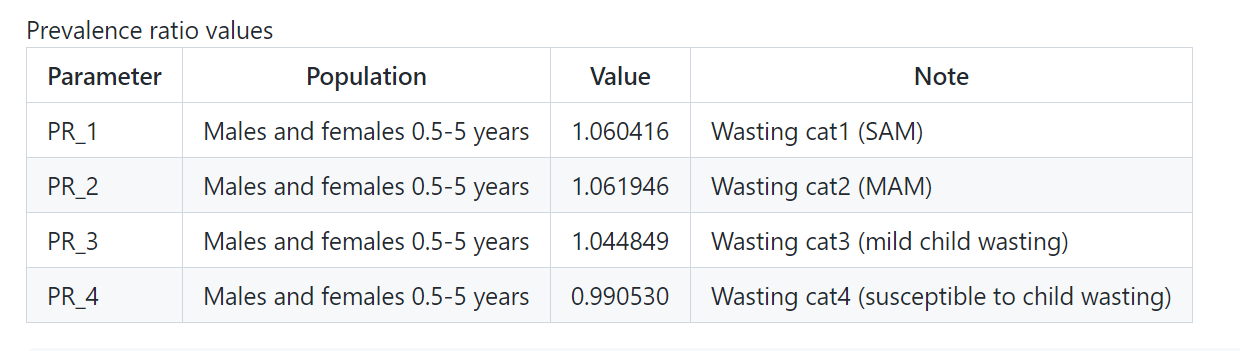

In [31]:
pr.reset_index().loc[(pr.reset_index().scenario=='baseline')
                    &(pr.reset_index().age=='2_to_4')]

# we're mostly looking too high for MAM

scenario     sex     age                         cause value            \
                                                           count      mean   
5   baseline  female  2_to_4            mild_child_wasting  11.0  1.011864   
6   baseline  female  2_to_4   moderate_acute_malnutrition  11.0  1.814167   
7   baseline  female  2_to_4     severe_acute_malnutrition  11.0  1.119793   
8   baseline  female  2_to_4  susceptible_to_child_wasting  11.0  0.926957   
9   baseline  female  2_to_4                        wasted  11.0  1.715786   
20  baseline    male  2_to_4            mild_child_wasting  11.0  1.012019   
21  baseline    male  2_to_4   moderate_acute_malnutrition  11.0  1.741993   
22  baseline    male  2_to_4     severe_acute_malnutrition  11.0  1.076727   
23  baseline    male  2_to_4  susceptible_to_child_wasting  11.0  0.917659   
24  baseline    male  2_to_4                        wasted  11.0  1.622200   

                                                                
         std       min      2.5%       50%     97.5%       max  
5   0.012028  0.993892  0.994334  1.015144  1.025395  1.025787  
6   0.035858  1.742556  1.753270  1.822039  1.869132  1.876236  
7   0.070354  1.025600  1.026106  1.106952  1.219405  1.220228  
8   0.006526  0.914167  0.915853  0.928201  0.937503  0.939469  
9   0.038915  1.636847  1.649822  1.707745  1.775262  1.782068  
20  0.007244  0.997563  0.999257  1.013341  1.023147  1.024932  
21  0.028324  1.698845  1.701684  1.735890  1.789861  1.793270  
22  0.068801  0.953235  0.967274  1.090912  1.170523  1.172818  
23  0.005741  0.904032  0.906473  0.918223  0.926160  0.927627  
24  0.026076  1.591736  1.592605  1.620991  1.668662  1.673141

In [22]:
# prevalence ratios are exaggerated in the sqlns scenario, which impacts both stunting and wasting
pr.reset_index().loc[(pr.reset_index().age=='12_to_23_months')
                    &(pr.reset_index().scenario.isin(['baseline','sqlns']))].set_index(['sex','cause','scenario'])[['value']].sort_index()

value                      \
                                             count      mean       std   
sex    cause                        scenario                             
female mild_child_wasting           baseline  11.0  1.018886  0.015444   
       moderate_acute_malnutrition  baseline  11.0  1.745419  0.066818   
       severe_acute_malnutrition    baseline  11.0  1.140272  0.080440   
       susceptible_to_child_wasting baseline  11.0  0.912054  0.007905   
       wasted                       baseline  11.0  1.631377  0.048435   
male   mild_child_wasting           baseline  11.0  1.017990  0.026338   
       moderate_acute_malnutrition  baseline  11.0  1.666272  0.036223   
       severe_acute_malnutrition    baseline  11.0  1.078528  0.068329   
       susceptible_to_child_wasting baseline  11.0  0.898431  0.012649   
       wasted                       baseline  11.0  1.525627  0.033887   

                                                                            \
                                                   min      2.5%       50%   
sex    cause                        scenario                                 
female mild_child_wasting           baseline  0.997929  0.999505  1.013214   
       moderate_acute_malnutrition  baseline  1.641936  1.651247  1.721564   
       severe_acute_malnutrition    baseline  1.007011  1.015497  1.147341   
       susceptible_to_child_wasting baseline  0.897469  0.898850  0.912262   
       wasted                       baseline  1.564335  1.572201  1.622589   
male   mild_child_wasting           baseline  0.983542  0.985385  1.014107   
       moderate_acute_malnutrition  baseline  1.624319  1.625007  1.663558   
       severe_acute_malnutrition    baseline  0.973812  0.978848  1.077197   
       susceptible_to_child_wasting baseline  0.879109  0.880342  0.900114   
       wasted                       baseline  1.478089  1.479430  1.518491   

                                                                  
                                                 97.5%       max  
sex    cause                        scenario                      
female mild_child_wasting           baseline  1.046644  1.050534  
       moderate_acute_malnutrition  baseline  1.847564  1.848014  
       severe_acute_malnutrition    baseline  1.233099  1.233639  
       susceptible_to_child_wasting baseline  0.921623  0.921646  
       wasted                       baseline  1.723752  1.732675  
male   mild_child_wasting           baseline  1.064774  1.066016  
       moderate_acute_malnutrition  baseline  1.732772  1.738543  
       severe_acute_malnutrition    baseline  1.180833  1.188395  
       susceptible_to_child_wasting baseline  0.916508  0.917008  
       wasted                       baseline  1.588818  1.604050

In [23]:
def compute_wasting_transition_rate(transition_count_parameter, person_time_state):
    rate = (((wasting_transitions.loc[wasting_transitions.measure==f'{transition_count_parameter}']
           .set_index(['input_draw','age']).drop(columns='measure'))
          / (wasting_person_time.loc[wasting_person_time.cause==f'{person_time_state}']
             .set_index(['input_draw','age']).drop(columns='cause')))
          .groupby(['age']).describe(percentiles=[0.025,0.975]).reset_index())
    rate['source_state'] = person_time_state.replace('_event_count','')
    rate['sink_state'] = transition_count_parameter
    return rate

In [24]:
wasting_transitions = pd.read_csv(output_dir +'wasting_transition_count.csv')
wasting_person_time = pd.read_csv(output_dir +'wasting_state_person_time.csv')

In [25]:
under_six_mo = wasting_transitions.loc[wasting_transitions.age.isin(['early_neonatal',
                                                                    'late_neonatal',
                                                                    '1-5_months'])]
non_zero = under_six_mo.loc[under_six_mo['value']!=0]
non_zero

# cool, no more transitions under six months of age

,Unnamed: 0,sex,year,measure,input_draw,scenario,value,diarrhea,sq_lns,mam_treatment,sam_treatment,age


In [26]:
non_zero.measure.unique()

array([], dtype=object)

In [30]:
transitions = ['susceptible_to_child_wasting_to_mild_child_wasting_event_count']
cause = 'susceptible_to_child_wasting'
transition_count = (wasting_transitions.loc[wasting_transitions.measure.isin(transitions)]
                    .groupby(['scenario','input_draw','age','sex','diarrhea']).sum()[['value']])
state_pt = (wasting_person_time.loc[wasting_person_time.cause==cause]
           .groupby(['scenario','input_draw','age','sex','diarrhea']).sum()[['value']])
rate = (transition_count / state_pt).reset_index()
rate = rate.loc[(rate.scenario=='baseline')&(rate.age.isin(['6-11_months','12_to_23_months','2_to_4']))]
rate_d = rate.loc[rate.diarrhea=='cat1'].set_index(['scenario','input_draw','age','sex'])[['value']]
rate_s = rate.loc[rate.diarrhea=='cat2'].set_index(['scenario','input_draw','age','sex'])[['value']]
rr = rate_d / rate_s
rr.groupby(['scenario','sex','age']).describe(percentiles=[0.025,0.975])


# i3 (tmrel to mild)
# 19 to 38... looking pretty high

value                                       \
                                count         mean          std        min   
scenario sex    age                                                          
baseline female 12_to_23_months  11.0    65.699476    71.327997  15.308998   
                2_to_4           11.0    54.849322    54.692827  14.870237   
                6-11_months      11.0   154.893221   436.561292   8.707147   
         male   12_to_23_months  11.0   125.646244   206.429162  17.000597   
                2_to_4           11.0    73.396459    90.644289  15.882100   
                6-11_months      11.0  1542.905345  5039.682865   9.063362   

                                                                     \
                                      2.5%        50%         97.5%   
scenario sex    age                                                   
baseline female 12_to_23_months  15.384465  29.856471    200.074434   
                2_to_4           15.010725  29.044127    156.488741   
                6-11_months       9.624541  21.498025   1118.681845   
         male   12_to_23_months  17.412146  34.062264    589.624157   
                2_to_4           15.976720  29.577216    266.509220   
                6-11_months      10.082842  22.419130  12568.587501   

                                               
                                          max  
scenario sex    age                            
baseline female 12_to_23_months    203.252084  
                2_to_4             160.208524  
                6-11_months       1470.407110  
         male   12_to_23_months    696.756679  
                2_to_4             298.721470  
                6-11_months      16738.062989

In [27]:
transitions = ['mild_child_wasting_to_moderate_acute_malnutrition_event_count']
cause = 'mild_child_wasting'
transition_count = (wasting_transitions.loc[wasting_transitions.measure.isin(transitions)]
                    .groupby(['scenario','input_draw','age','sex','diarrhea']).sum()[['value']])
state_pt = (wasting_person_time.loc[wasting_person_time.cause==cause]
           .groupby(['scenario','input_draw','age','sex','diarrhea']).sum()[['value']])
rate = (transition_count / state_pt).reset_index()
rate = rate.loc[(rate.scenario=='baseline')&(rate.age.isin(['6-11_months','12_to_23_months','2_to_4']))]
rate_d = rate.loc[rate.diarrhea=='cat1'].set_index(['scenario','input_draw','age','sex'])[['value']]
rate_s = rate.loc[rate.diarrhea=='cat2'].set_index(['scenario','input_draw','age','sex'])[['value']]
rr = rate_d / rate_s
rr.groupby(['scenario','sex','age']).describe(percentiles=[0.025,0.975])


# i2 (mild to mam)
# 30 to 60
# looks good, actually

value                                   \
                                count       mean        std        min   
scenario sex    age                                                      
baseline female 12_to_23_months  11.0  34.599576   3.604595  29.753446   
                2_to_4           11.0  41.626939   5.310735  34.908903   
                6-11_months      11.0  54.548447  17.922448  33.983666   
         male   12_to_23_months  11.0  28.497185   3.792927  23.376416   
                2_to_4           11.0  35.975190   4.234972  30.782214   
                6-11_months      11.0  35.869628   9.931820  24.455883   

                                                                             
                                      2.5%        50%      97.5%        max  
scenario sex    age                                                          
baseline female 12_to_23_months  30.016880  33.404340  40.555623  40.734497  
                2_to_4           35.167576  41.645241  50.455040  50.968575  
                6-11_months      34.855759  51.922528  88.575264  90.826908  
         male   12_to_23_months  23.857194  28.117358  35.734437  37.326285  
                2_to_4           31.030690  35.710047  43.334166  44.270323  
                6-11_months      25.233021  33.479086  56.863239  60.882567

In [29]:
transitions = ['moderate_acute_malnutrition_to_severe_acute_malnutrition_event_count']
cause = 'moderate_acute_malnutrition'
transition_count = (wasting_transitions.loc[wasting_transitions.measure.isin(transitions)]
                    .groupby(['scenario','input_draw','age','sex','diarrhea']).sum()[['value']])
state_pt = (wasting_person_time.loc[wasting_person_time.cause==cause]
           .groupby(['scenario','input_draw','age','sex','diarrhea']).sum()[['value']])
rate = (transition_count / state_pt).reset_index()
rate = rate.loc[(rate.scenario=='baseline')&(rate.age.isin(['6-11_months','12_to_23_months','2_to_4']))]
rate_d = rate.loc[rate.diarrhea=='cat1'].set_index(['scenario','input_draw','age','sex'])[['value']]
rate_s = rate.loc[rate.diarrhea=='cat2'].set_index(['scenario','input_draw','age','sex'])[['value']]
rr = rate_d / rate_s
rr.groupby(['scenario','age','sex']).describe(percentiles=[0.025,0.975])

# i1
# validation ~1
# looks good

value                                          \
                                count      mean       std       min      2.5%   
scenario age             sex                                                    
baseline 12_to_23_months female  11.0  1.274022  0.257342  0.881400  0.884339   
                         male    11.0  1.363775  0.224281  1.023969  1.073926   
         2_to_4          female  11.0  1.325882  0.272721  0.799965  0.841263   
                         male    11.0  1.352035  0.182424  1.153053  1.162359   
         6-11_months     female  11.0  1.632514  0.419630  0.989876  1.051994   
                         male    11.0  1.586843  0.260204  1.235493  1.253985   

                                                               
                                      50%     97.5%       max  
scenario age             sex                                   
baseline 12_to_23_months female  1.276615  1.684219  1.716480  
                         male    1.317088  1.789363  1.825512  
         2_to_4          female  1.422227  1.636884  1.653800  
                         male    1.314954  1.687741  1.717379  
         6-11_months     female  1.545385  2.184304  2.196785  
                         male    1.537150  2.011253  2.048992

# diarrhea transitions stratified by wasting state

In [44]:
dt = pd.read_csv(output_dir + 'diarrhea_transition_count.csv')
dpt = pd.read_csv(output_dir + 'diarrhea_state_person_time.csv')
six_to_59_ages = ['6-11_months',
       '12_to_23_months', '2_to_4']
ages = ['6-11_months',
       '12_to_23_months', '2_to_4']

In [41]:
dt.measure.unique()

array(['diarrheal_diseases_to_susceptible_to_diarrheal_diseases_event_count',
       'susceptible_to_diarrheal_diseases_to_diarrheal_diseases_event_count'],
      dtype=object)

In [42]:
dt.head()

,Unnamed: 0,sex,year,measure,input_draw,scenario,value,preventative_zinc,therapeutic_zinc,wasting_state,age
0,0,female,2022,diarrheal_diseases_to_susceptible_to_diarrheal...,29,baseline,0.0,covered,covered,susceptible_to_child_wasting,early_neonatal
1,1,female,2022,diarrheal_diseases_to_susceptible_to_diarrheal...,29,baseline,51.0,uncovered,covered,susceptible_to_child_wasting,early_neonatal
2,2,female,2022,diarrheal_diseases_to_susceptible_to_diarrheal...,29,baseline,0.0,covered,uncovered,susceptible_to_child_wasting,early_neonatal
3,3,female,2022,diarrheal_diseases_to_susceptible_to_diarrheal...,29,baseline,184.0,uncovered,uncovered,susceptible_to_child_wasting,early_neonatal
4,4,female,2022,diarrheal_diseases_to_susceptible_to_diarrheal...,29,baseline,0.0,covered,covered,mild_child_wasting,early_neonatal


In [50]:
((dt.loc[(dt.measure=='diarrheal_diseases_to_susceptible_to_diarrheal_diseases_event_count')
       &(dt.age.isin(ages))].groupby(['input_draw','wasting_state']).sum()[['value']])
/ (dpt.loc[(dpt.cause=='diarrheal_diseases')&(dpt.age.isin(ages))]
  .groupby(['input_draw','wasting_state']).sum()[['value']])).groupby('wasting_state').mean()

,value
wasting_state,
mild_child_wasting,79.846226
moderate_acute_malnutrition,79.943276
severe_acute_malnutrition,79.748821
susceptible_to_child_wasting,79.889907


In [54]:
((dt.loc[(dt.measure=='susceptible_to_diarrheal_diseases_to_diarrheal_diseases_event_count')
       &(dt.age.isin(ages))].groupby(['input_draw','wasting_state']).sum()[['value']])
/ (dpt.loc[(dpt.cause=='susceptible_to_diarrheal_diseases')&(dpt.age.isin(ages))]
  .groupby(['input_draw','wasting_state']).sum()[['value']])).groupby('wasting_state').mean()

,value
wasting_state,
mild_child_wasting,1.796203
moderate_acute_malnutrition,1.900864
severe_acute_malnutrition,1.952086
susceptible_to_child_wasting,1.746038
